# Classification of individuals movements based on RSS signal temporal data 



## 1 Problem Statement

Four Wireless Sensor Network (WSN) (A1-A4) are placed across two rooms. These WSN comprise of variable sensors that generate high-frequency RSS signal data that can detect event of objects in their range. One sensor is worn by the user. Data has been collected during user movements at the frequency of 8 Hz (8 samples per second)

Experimentation gathered information on 6 prototypical paths that are shown in Figure below with arrows numbered from 1 to 6: two movement types are considered for the prediction task, that are straight and curved trajectories.  Straight movements run from Room 1 to Room 2 or viceversa (paths 1 and 5  in Figure below) and yields to a change in the spatial context of the user, while curved movements (paths 2, 3, 4 and 6 in Figure below) maintain the same spatial context. 

![](images/motionsensors.png)

The measurement campaign comprises experiments on three different couple of rooms with a total surface spanning from 50 $m^2$ to about 60 $m^2$.

![](images/motionsensors2.png)

The objective is to identify whether an individual has moved across rooms, based on the data captured from these sensors.



**Reference**

[1] D. Bacciu, P. Barsocchi, S. Chessa, C. Gallicchio, and A. Micheli, "An experimental characterization of reservoir computing in ambient assisted living applications", Neural Computing and Applications, Springer-Verlag, vol. 24 (6), pp. 1451-1464, doi:10.1007/s00521-013-1364-4, ISSN 0941-0643, 2014.
http://wnlab.isti.cnr.it/paolo/index.php/dataset/6rooms

## 2 Time seriese classification
Time series classification (TSC) is an important part of the data mining yet, deep neural network implementation has been limited to academia and research centers, and has not been adapted by the industry. TSC data differes from a regular classification since the attributes have an ordered sequence.

Since 2015, handread of TSC algorithms have been proposed (Bagnall et al., 2017). One of the most popular and traditional TSC approaches is the use of a nearest neughbor classifier coupled with a distance function (Lines and Bagnall, 2015). Particulary, the Dynamic Time Warping (DTW) distance when used with a NN classifier has been show to be a ery strong baseline. (Bagnall, 2017). 

Here I will implment LTSM classification model for RSS signal data.


## 3 Dataset Descriptions

* **MovementAAL_RSS_SEQID.csv**: Input data 

    Input RSS streams are provided, where **SEQID** is the progressive numeric sequence ID. 
    The RSS signals have been normalized to the interval [-1,1].
    In each file, each row corresponds to a time step measurement (in temporal order) and contains the following information: 

    - RSS_anchor1
    - RSS_anchor2
    - RSS_anchor3
    - RSS_anchor4 

* **MovementAAL_target.csv**: Target data 

    Each row in this file contains: 

    - sequence_ID
    - class_label 


* **MovementAAL_DatasetGroup.csv**: Dataset grouping

    Data is grouped in 3 sets, as described in the previous section. 

    Each row in this file contains:

    - sequence_ID
    - dataset_ID 

* **MovementAAL_Paths.csv**: Path grouping 

    Users' movements are divided in 6 prototypical paths, as described in the previous section. 

    Each row in this file contains: 
    
    - sequence_ID
    - path_ID

## 4 Load Packages

In [1]:
import numpy as np
import os
import zipfile
from skimage import io
import requests
import zipfile
import util as util
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from scipy import stats
import math

In [2]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 5 Download and Unzip Datasets

In [3]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00348/MovementAAL.zip'

In [4]:
util.download_training_data(url)

downloading training data...


## 6 Exploratory Data Analysis

In [5]:
df1=pd.read_csv('data/dataset/MovementAAL_RSS_1.csv')
df10=pd.read_csv('data/dataset/MovementAAL_RSS_10.csv')
df1.head()

,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [6]:
print("df1")
print(df1.describe())
print("df10")
print(df10.describe())

df1
       #RSS_anchor1   RSS_anchor2   RSS_anchor3   RSS_anchor4
count     27.000000     27.000000     27.000000     27.000000
mean      -0.232805     -0.082963     -0.077601      0.088889
std        0.216344      0.185614      0.240700      0.299465
min       -0.904760     -0.600000     -0.619050     -0.800000
25%       -0.309520     -0.200000     -0.285710     -0.075000
50%       -0.142860     -0.040000     -0.047619      0.150000
75%       -0.095238      0.040000      0.142860      0.325000
max        0.000000      0.160000      0.285710      0.500000
df10
       #RSS_anchor1   RSS_anchor2   RSS_anchor3   RSS_anchor4
count     25.000000     25.000000     25.000000     25.000000
mean      -0.066666     -0.136000     -0.140953      0.066000
std        0.162068      0.215097      0.246089      0.210515
min       -0.428570     -0.760000     -0.714290     -0.350000
25%       -0.190480     -0.200000     -0.285710     -0.100000
50%        0.000000     -0.080000     -0.142860      0.050000

In [7]:
df1.shape,df10.shape,

((27, 4), (25, 4))

Apparently, the number of records are not consistent. The first file contains data from 27 seconds while the tenth data contains data from 25 seconds.

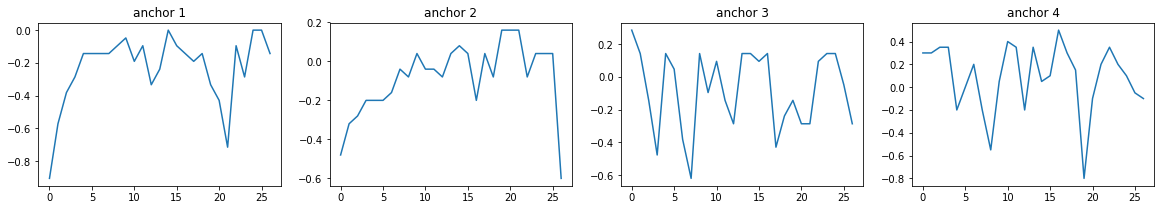

In [8]:
plt.figure(1, figsize=(20, 3))

plt.subplot(141)
plt.title("anchor 1")
plt.plot(df1.index, df1.iloc[:,0])
plt.subplot(142)
plt.title("anchor 2")
plt.plot(df1.index, df1.iloc[:,1])
plt.subplot(143)
plt.title("anchor 3")
plt.plot(df1.index, df1.iloc[:,2])
plt.subplot(144)
plt.title("anchor 4")
plt.plot(df1.index, df1.iloc[:,3])


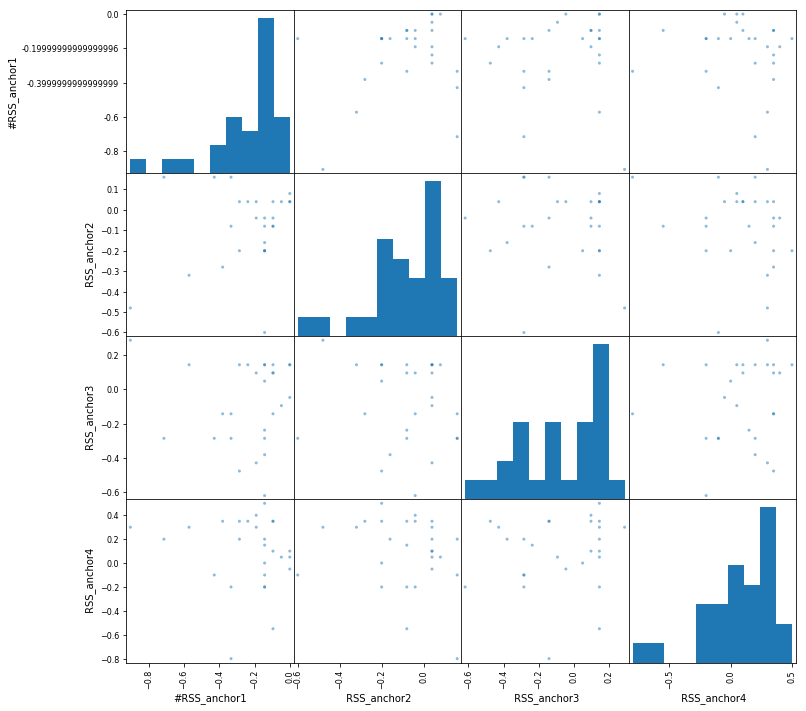

In [9]:
pd.plotting.scatter_matrix(df1.iloc[:,0:4], 
                           figsize=(12, 12))
plt.show()

There are no apparent relationship between these anchors.

## 7 - Load data

### 7.1 - Input Data

In [10]:
path='data/dataset/MovementAAL_RSS_'
df=[]
for i in range(1,315,1):
    df.append(pd.read_csv(path+str(i)+'.csv').values)

In [11]:
df[0]

array([[-0.90476 , -0.48    ,  0.28571 ,  0.3     ],
       [-0.57143 , -0.32    ,  0.14286 ,  0.3     ],
       [-0.38095 , -0.28    , -0.14286 ,  0.35    ],
       [-0.28571 , -0.2     , -0.47619 ,  0.35    ],
       [-0.14286 , -0.2     ,  0.14286 , -0.2     ],
       [-0.14286 , -0.2     ,  0.047619,  0.      ],
       [-0.14286 , -0.16    , -0.38095 ,  0.2     ],
       [-0.14286 , -0.04    , -0.61905 , -0.2     ],
       [-0.095238, -0.08    ,  0.14286 , -0.55    ],
       [-0.047619,  0.04    , -0.095238,  0.05    ],
       [-0.19048 , -0.04    ,  0.095238,  0.4     ],
       [-0.095238, -0.04    , -0.14286 ,  0.35    ],
       [-0.33333 , -0.08    , -0.28571 , -0.2     ],
       [-0.2381  ,  0.04    ,  0.14286 ,  0.35    ],
       [ 0.      ,  0.08    ,  0.14286 ,  0.05    ],
       [-0.095238,  0.04    ,  0.095238,  0.1     ],
       [-0.14286 , -0.2     ,  0.14286 ,  0.5     ],
       [-0.19048 ,  0.04    , -0.42857 ,  0.3     ],
       [-0.14286 , -0.08    , -0.2381  ,  0.15

### 7.2 - Target Data

In [12]:
targets=pd.read_csv('data/dataset/MovementAAL_target.csv', header=0).values[:,1]

In [13]:
targets.shape

(314,)

There is one target per file

### 7.3 - Groups

In [14]:
groups=pd.read_csv('data/groups/MovementAAL_DatasetGroup.csv', header=0).values[:,1]

In [15]:
groups.shape

(314,)

In [16]:
np.unique(groups, return_counts=True)

(array([1, 2, 3]), array([104, 106, 104]))

### 7.4 Paths

In [17]:
paths=pd.read_csv('data/groups/MovementAAL_Paths.csv', header=0).values[:,1]

In [18]:
paths.shape

(314,)

## 8. Data Preprocess


The length of each file need to match so I would need to pad/drop records. 

In [19]:
length=np.array(list(map(lambda x: len(x), df)))
stats.describe(length)

DescribeResult(nobs=314, minmax=(19, 129), mean=42.02866242038217, variance=261.96403207097944, skewness=1.0009054111936921, kurtosis=2.996032708933482)

In [20]:
np.unique(length, return_counts=True)

(array([ 19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  74, 103,
        119, 129]),
 array([ 1,  8,  3,  8, 15, 15, 11, 19, 12,  3,  6,  2,  2,  2,  2,  2,  7,
         5,  8,  5,  9,  8, 14, 11,  5,  3,  7,  3,  4,  1,  1,  2,  6,  4,
         2,  8,  8, 15,  7,  5, 12,  7,  8,  5,  4,  6,  5,  2,  1,  1,  1,
         1,  1,  1]))

Minimum length is 19 seconds and the maximum length is 129 seconds. Only one file has 129 seconds.

In [21]:
stats.scoreatpercentile(length, 95)

64.0

The length is 64 seconds for 95 percentil, so I will set the length of all files to be 64 and 
I will pad the sequence by repeating the rows $x$ times where $x=\lceil \frac{64}{\text{min length of data}} \rceil$ 

In [22]:
final_length=64
multi=math.ceil(final_length/stats.describe(length)[1][0])

In [23]:
final_df1=util.df_padd1(final_length, df)
#final_df1[5].shape

Second method is to just pad the last row.

In [24]:
final_df2=util.df_padd2(final_length, df)
#final_df2

Next, `final_df` will be split based on the groups.

* If group==1 $\leftarrow$ dev
* If group==2 $\leftarrow$ train
* If group==3 $\leftarrow$ test

In [25]:
train_X,  dev_X,  test_X,  train_Y,  dev_Y,  test_Y  = util.train_dev_test(final_df1,groups,targets)
train_X2, dev_X2, test_X2, train_Y2, dev_Y2, test_Y2 = util.train_dev_test(final_df2,groups,targets)
#train_X3, dev_X3, test_X3, train_Y3, dev_Y3, test_Y3 = util.train_dev_test(final_df3,groups,targets)

# 9. Building a TSC using LSTM 

In [26]:
model = Sequential()
model.add(LSTM(256, input_shape=(final_length, 4)))
#model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
#chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(final_length, 4)))
#model2.add(Dense(3, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = Adam(lr=0.001)
chk2 = ModelCheckpoint('best_model2.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
#chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [28]:
model3 = Sequential()
model3.add(LSTM(400, input_shape=(80, 4)))
#model2.add(Dense(3, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = Adam(lr=0.001)
chk3 = ModelCheckpoint('best_model3.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
#chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 400)               648000    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 648,401
Trainable params: 648,401
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [29]:
history1 =model.fit(train_X, train_Y, epochs=200, batch_size=128, callbacks=[chk], validation_data=(dev_X,dev_Y))

Train on 106 samples, validate on 104 samples
Epoch 1/200
106/106 [==============================] - 2s 22ms/step - loss: 0.7035 - acc: 0.4245 - val_loss: 0.6929 - val_acc: 0.5288

Epoch 00001: val_acc improved from -inf to 0.52885, saving model to best_model.pkl
Epoch 2/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6893 - acc: 0.6792 - val_loss: 0.6860 - val_acc: 0.6346

Epoch 00002: val_acc improved from 0.52885 to 0.63462, saving model to best_model.pkl
Epoch 3/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6765 - acc: 0.6132 - val_loss: 0.6802 - val_acc: 0.6635

Epoch 00003: val_acc improved from 0.63462 to 0.66346, saving model to best_model.pkl
Epoch 4/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6636 - acc: 0.5943 - val_loss: 0.6749 - val_acc: 0.6635

Epoch 00004: val_acc did not improve from 0.66346
Epoch 5/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6495 - acc: 0.5943 - val_loss: 0.66

In [30]:
#loading the model and checking accuracy on the test data
model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test_X)
accuracy_score(test_Y, test_preds)

0.7692307692307693

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


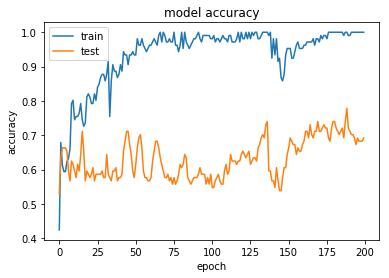

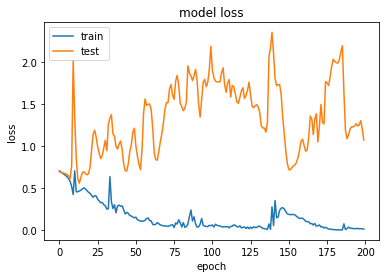

In [31]:
util.historyplot(history1)

In [32]:
history2 =model2.fit(train_X2, train_Y2, epochs=200, batch_size=128, callbacks=[chk2], validation_data=(dev_X2,dev_Y2))

Train on 106 samples, validate on 104 samples
Epoch 1/200
106/106 [==============================] - 2s 21ms/step - loss: 0.6956 - acc: 0.4623 - val_loss: 0.6865 - val_acc: 0.5577

Epoch 00001: val_acc improved from -inf to 0.55769, saving model to best_model2.pkl
Epoch 2/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6847 - acc: 0.5377 - val_loss: 0.6779 - val_acc: 0.6154

Epoch 00002: val_acc improved from 0.55769 to 0.61538, saving model to best_model2.pkl
Epoch 3/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6742 - acc: 0.6132 - val_loss: 0.6692 - val_acc: 0.5962

Epoch 00003: val_acc did not improve from 0.61538
Epoch 4/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6631 - acc: 0.6132 - val_loss: 0.6599 - val_acc: 0.6058

Epoch 00004: val_acc did not improve from 0.61538
Epoch 5/200
106/106 [==============================] - 0s 4ms/step - loss: 0.6500 - acc: 0.6132 - val_loss: 0.6498 - val_acc: 0.6058

Epoch 00005:

In [33]:
#loading the model and checking accuracy on the test data
model2 = load_model('best_model2.pkl')

from sklearn.metrics import accuracy_score
test_preds = model2.predict_classes(test_X2)
accuracy_score(test_Y2, test_preds)

0.6346153846153846

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


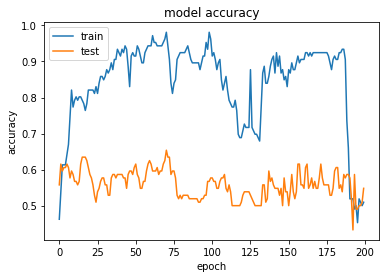

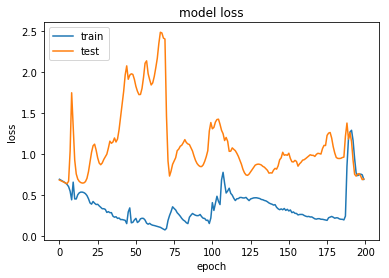

In [34]:
util.historyplot(history2)

In [35]:
#history3 =model3.fit(train_X3, train_Y3, epochs=200, batch_size=128, callbacks=[chk3], validation_data=(dev_X3,dev_Y3))

## Summary

The LSTM model achived 77% for RRS signal time seriese data.